# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *
from matlab.function_EMCCD_CMOS_calib import *

In [3]:
import PIL
import PIL.ExifTags as Exiftags

In [4]:
from matlab.tifmethods import readBigTifFile

In [5]:
windows = True
if windows:
    fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
else:
    fname = '/mnt/data/Anastasia/sample folder with NR data/image files/cell1_BeRST.tif'
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c752c34940>)

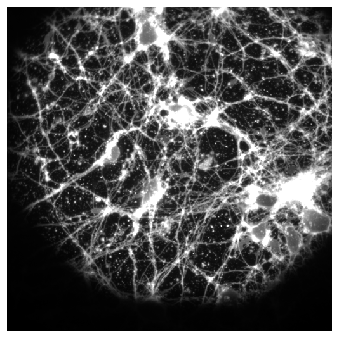

In [6]:
visualization(movie)

In [8]:
if windows:
    folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
    fname = r"\wave\cell4_7.tif"
    fwave = r"\wave\cell4_7.tif"
    fctrl = r"\control\cell4_8.tif"
    file_Berst='\cell4_BeRST.tif'
    foldercalib = "\EMCCD-CMOS calib\\"
else:
    folder = '/mnt/data/Anastasia/sample folder with NR data/image files/'
    fname = 'wave/cell1_1.tif'
    fwave = 'wave/cell1_1.tif'
    fctrl = 'control/cell1_2.tif'
    file_Berst='cell1_BeRST.tif'
    foldercalib = "EMCCD-CMOS calib/"


In [12]:
temp=loadtxt(folder+'\\..\\103.txt')

In [18]:
Signal_2ch_OnState_wave=temp[:,:1]
Ratio_wave=temp[:,1:]

In [15]:
def stitchedtrace(x,framesxperiod = 4, index = False):
    size = x.shape[0]
    if size % framesxperiod != 0:
        print('Not divisible by %i!' % framesxperiod)
        return x
    xb = x.reshape(size//framesxperiod,framesxperiod)
    idx = arange(size).reshape(size//framesxperiod,framesxperiod)
    sel = isnan(xb.sum(axis=1))
    xb[sel,:] = nan
    # only those periods that are not nans go to new index
    idx = idx[~sel,:]
    xb = xb[~sel,:]
   
    if index:
        return(xb.flatten(),idx.flatten())
    return(xb.flatten())


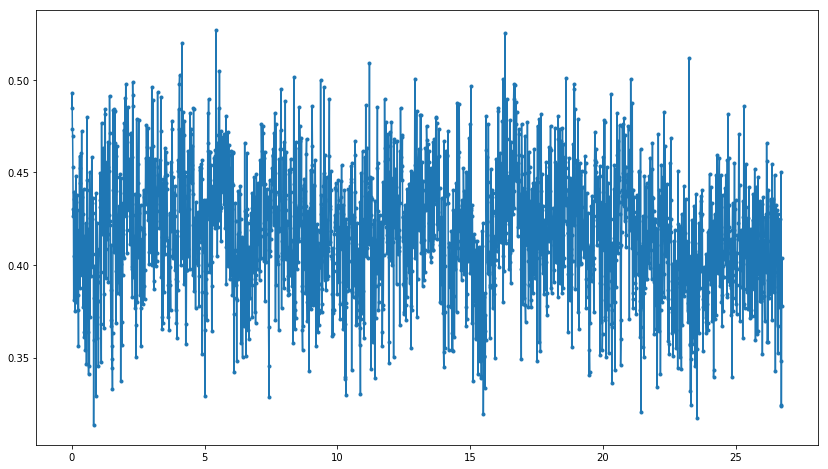

In [20]:
figure(figsize=(14,8))
xt=stitchedtrace(Signal_2ch_OnState_wave[:,0])
plot(arange(xt.shape[0])*.01,xt,'.-')
#plot(arange(xt.shape[0])*.01,stitchedtrace(xt,framesxperiod=4),'.-')
#xtb, idx = stitchedtrace(xt,framesxperiod=4,index = True)
#plot(idx*.01,xt[idx],'.-')
#xlim(0,5)

In [21]:
Signal_2ch_OnState_wave.shape

(6000, 1)

##    Extracting Signal
### FT score calculation
### Interval extraction



In [22]:
#import matlab.Burstmethods as bst 
def running_mean(x, N, padding = "valid"):
    if padding =="same":
        N2 = N//2
        Nf = float(N)
        cumsumt = cumsum(concatenate((zeros(1),x,zeros(N-1))))
        runmean = (cumsumt[N:] - cumsumt[:-N]) / Nf
        runmean[-N+1:] = runmean[-N+1:]*Nf/(arange(Nf-1,0,-1))
    elif padding =="valid":
        cumsumt = cumsum(insert(x, 0, 0))
        runmean = (cumsumt[N:] - cumsumt[:-N]) / float(N)
    return(runmean)
    
def burstsearch(dS,thf=0.6,ncycles = 12, merged = True,returnstat = False):
    ''' It returns a set of pairs of numbers with the index of the beggining 
    and last cycle in a row in a burst interval
    '''
    Ssc = (running_mean(dS,ncycles))**2
    threshold = (max(Ssc)-min(Ssc))*thf+min(Ssc)

    sel = arange(Ssc.shape[0])[Ssc>threshold]
    #sel = sel[(sel>0)*(sel<Ssc.shape[0]-12)]
    csel = sel[1:]-sel[:-1]
    s0 = 0
    ssel = []
    for i,si in enumerate(csel):
        if si>1:
            ssel.append([sel[s0],sel[i]])
            s0 = i+1
    ssel.append([sel[s0],sel[-1]])

    bsel = []
    for s in ssel:
        bsel.append([s[0],s[1]+12])

    bselm = []
    if merged:
        bs0a = bsel[0][0]
        bs1a = bsel[0][1]
        for bs in bsel[1:]:
            bs0 = bs[0]
            bs1 = bs[1]
            if bs1a< bs0:
                bselm.append([bs0a,bs1a])
                bs0a = bs0
            bs1a = bs1
        bselm.append([bs0a,bs1a])
    else:
        bselm = bsel
        
    if returnstat:
        Ssc.sort()
        Smedian = Ssc[len(Ssc)//2]
        return(bselm,(Ssc.max(),Ssc.mean(),Smedian))
    else:
        return(bselm)
    
def overlapintervals(int0,int1):
    di0 = int0[:,1]-int0[:,0]
    di1 = int1[:,1]-int1[:,0]
    
    total0 = di0.sum()
    total1 = di1.sum()
    if total1 >total0:
        overlap = overlapintervals(int1,int0)
        return(overlap)

    int1l = len(int1)
    overlap = 0
    k = 0
    for s0,s1 in int0:
        while k<int1l:
            t0,t1 = int1[k]
            if t1< s0:
                k +=1
            elif t1<= s1:
                overlap+= t1-max(t0,s0)
                k += 1
                break
            elif t1>s1:
                if t0<s1:
                    overlap += t1-max(t0,s0)
                    
                break
                    
    return( overlap/total1, total0-total1)

def burstscore(b,dS, Fav = 1, idx= None, plot = False):
    Sscore = zeros((b.shape[0],4))
    if idx is None:
        idx  = arange(dS.shape[0])*2
    for i,bs in enumerate(b):
        # ~ print(bs[0],bs[1],dS.shape,idx.shape)
        dSt = dS[bs[0]:bs[1]] 
        t0,tf = idx[bs[0]:bs[1]][array([0,-1])]
        tf += 2
        # Burst score, S= sum dF/F, and burst score per time 
        # (S2 and Sn are there to calculate error bars later for S/time) 
        Sscore[i,:] = ((dSt).sum()/Fav,(dSt*dSt).sum()/Fav**2, dSt.shape[0],tf-t0)
        
    return(Sscore)

In [23]:
def normalize(signal, norm=0):
    Nframes = signal.shape[0]
    if Nframes % 4 != 0:
        print('Not divisible by 4')
        return signal
    sig=signal.reshape(Nframes//4,4)
    sm=sig[:,2:].mean(axis=1, keepdims=True)
    if norm==0:
        sig=(sig-sm)/sm
    elif norm==1:
        sig=sig-sm
    
    return sig.flatten()


In [24]:
def average2(signal):
    Nframes = signal.shape[0]
    if Nframes % 4 != 0:
        print('Not divisible by 4')
        return signal
    sig=signal.reshape(Nframes//4,4)
    sm1=sig[:,:2].mean(axis=1, keepdims=True)
    sm2=sig[:,2:].mean(axis=1, keepdims=True)
    sig=column_stack((sm1,sm2))
    return sig.flatten()

(0, 1)

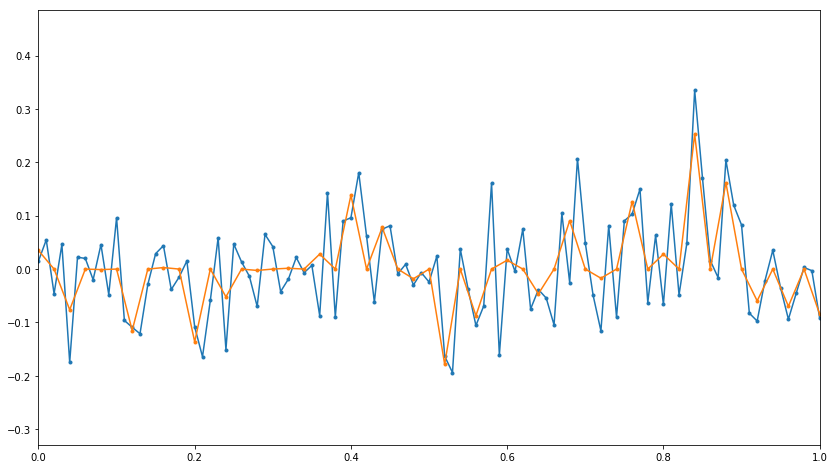

In [25]:
figure(figsize=(14,8))
xt=stitchedtrace(Signal_2ch_OnState_wave[:,0])

xt=normalize(xt)
xa=average2(xt)
plot(arange(xt.shape[0])*.01,xt,'.-')
plot(arange(xa.shape[0])*.02,xa,'.-')
xlim(0,1)

In [44]:
print(xa[200])

0.045134260140925406


In [26]:
def get_intervals_fixedth(Sn,pth=0,probl = 0.0):
    threshold = pth
    prob = sum(Sn>threshold)/len(Sn)
    intervals = []
    if prob>probl:
        Stn = array(Sn)
        sel = Stn<threshold
        Stn[sel] = 0.0
        csel = cumsum(1-sel)
        selt = 0
        ica = 0
        on = True
        for ic,c in enumerate(csel):
            if c == selt:
                if not on:
                    intervals.append([ica,ic])
                    ica = ic
                on = True
            else:
                if on:
                    intervals.append([ica,ic])
                    ica = ic
                    selt = c
                selt = c
                on = False
        return intervals
    else:
        print("Not enough points in the second gaussian!")
        return nan


In [27]:
def int_int(signal, intervals, dt=1):
    cs=cumsum(((signal[0:-1]+signal[1:])*dt)/2)
    intSUM=zeros(intervals.shape[0])
    for i in range(intervals.shape[0]):
        intSUM[i]=cs[intervals[i,1]-1]-cs[intervals[i,0]]
    return intSUM

In [28]:
def score_int(signal, norm, wind=10):

    Sn=normalize(stitchedtrace(signal),norm)
    Sa=average2(Sn)

    dS=Sa[arange(0,Sa.shape[0],2)]

    dSa10=running_mean(dS, wind, 'same')


    intS=array(get_intervals_fixedth(dSa10))
    temp=intS[:,1]-intS[:,0]>1

    intS=intS[temp,:]
    signS=sign(dSa10[intS[:,0]])

    scoreS=int_int(dSa10, intS)
    return (intS, signS, scoreS)


In [29]:
def run_score(signal, norm, wind=10):    
    Sn=normalize(stitchedtrace(signal),norm)
    Sa=average2(Sn)

    dS=Sa[arange(0,Sa.shape[0],2)]

    dSa10=running_mean(dS, wind, 'same')
    return(dSa10)

In [54]:
roi=0
Fw=Signal_2ch_OnState_wave[:,roi]
Rw=Ratio_wave[:,roi]
#Fc=Signal_2ch_OnState_ctrl[:,roi]
#Rc=Ratio_ctrl[:,roi]

intFw, signFw, scoreFw=score_int(Fw, 0)
#intFc, signFc, scoreFc=score_int(Fc, 0)
intRw, signRw, scoreRw=score_int(Rw, 0)
#intRc, signRc, scoreRc=score_int(Rc, 0)


In [60]:
thF=0.6676#mean(scoreFc)+std(scoreFc)*1
#thR=mean(scoreRc)+std(scoreRc)*1

crit=abs(scoreFw)>thF
intFw[crit,:]

array([[ 69,  84],
       [269, 314],
       [352, 383],
       [447, 501],
       [560, 577]])

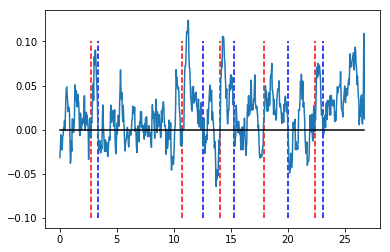

In [62]:
xt=run_score(Fw,0)
Tacq=0.01
temp=intFw[crit,:]*Tacq*4
x=arange(0,xt.shape[0])*Tacq*4
plot(x,xt)
plot(x,xt*0, 'k')
vlines(temp[:,0], -0.1, 0.1, linestyles='--', color='r')
vlines(temp[:,1], -0.1, 0.1,linestyles='--', color='b')

##   Bootstrap?

